### MAL Project - Mobile Churn Forecasting
Mattéo Rousseau & Massil Gouachi


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier


#--- Data importation ---
cell = pd.read_csv("celldata.csv")

features = [feature for feature in cell.columns if feature != "Churn"]
X, y = cell[features].copy(), cell[["Churn"]].copy()

types = {
    "CreditScore": "int64",
    "Age": "int64",
    "Tenure": "int64",
    "Balance": "float64",
    "NumOfProducts": "int64",
    "Salary": "int64",
    "Geography": "category",
    "Gender": "category",
    "HasCrCard": "boolean",
    "IsActiveMember": "boolean",
}

X = X.astype(types)
y = y.astype({"Churn": "boolean"})

### Part I - Data exploration

In [56]:
cell.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1
1,649,France,Female,42,7,0.00,2,0,1,22974,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0


In [57]:
cell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-null   object 
 2   Gender          8000 non-null   object 
 3   Age             8000 non-null   int64  
 4   Tenure          8000 non-null   int64  
 5   Balance         8000 non-null   float64
 6   NumOfProducts   8000 non-null   int64  
 7   HasCrCard       8000 non-null   int64  
 8   IsActiveMember  8000 non-null   int64  
 9   Salary          8000 non-null   int64  
 10  Churn           8000 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 687.6+ KB


In [58]:
cell.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,650.805000,38.871625,5.013000,76011.635494,1.533625,0.704750,0.515750,100211.396750,0.201125
std,96.721648,10.446006,2.897565,62402.105212,0.583448,0.456184,0.499783,57165.688096,0.400866
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51464.500000,0.000000
50%,652.000000,37.000000,5.000000,96846.565000,1.000000,1.000000,1.000000,100583.000000,0.000000
75%,718.000000,44.000000,7.000000,127593.625000,2.000000,1.000000,1.000000,149068.000000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.000000,1.000000


In [59]:
cell.isna().sum()

CreditScore       0
Geography         0
Gender            0
Age               0
Tenure            0
Balance           0
NumOfProducts     0
HasCrCard         0
IsActiveMember    0
Salary            0
Churn             0
dtype: int64

In [60]:
cat_cols = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
num_cols = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "Salary"]

X[cat_cols].nunique()

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
dtype: int64

In [61]:
X[cat_cols].value_counts()

Geography  Gender  HasCrCard  IsActiveMember
France     Male    True       True              828
                              False             756
           Female  True       True              646
                              False             612
Spain      Male    True       True              405
Germany    Male    True       True              386
                              False             367
           Female  True       False             357
Spain      Male    True       False             357
France     Male    False      True              329
                              False             313
Spain      Female  True       True              310
Germany    Female  True       True              308
Spain      Female  True       False             306
France     Female  False      True              282
                              False             272
Spain      Male    False      True              196
                              False             154
Germany    Male    

=== Barplots des variables catégorielles ===


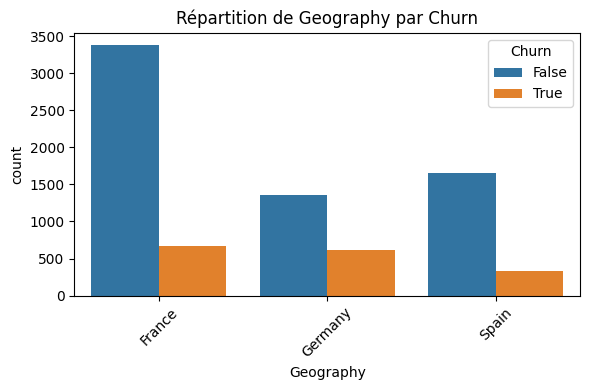

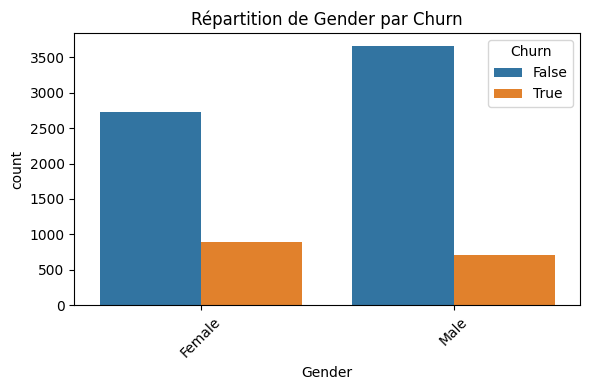

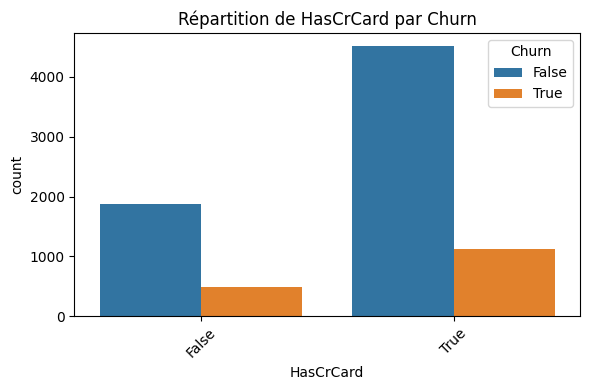

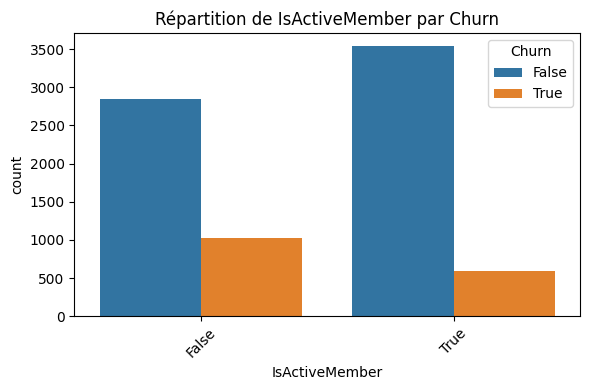

=== Histogrammes & Boxplots des variables numériques ===


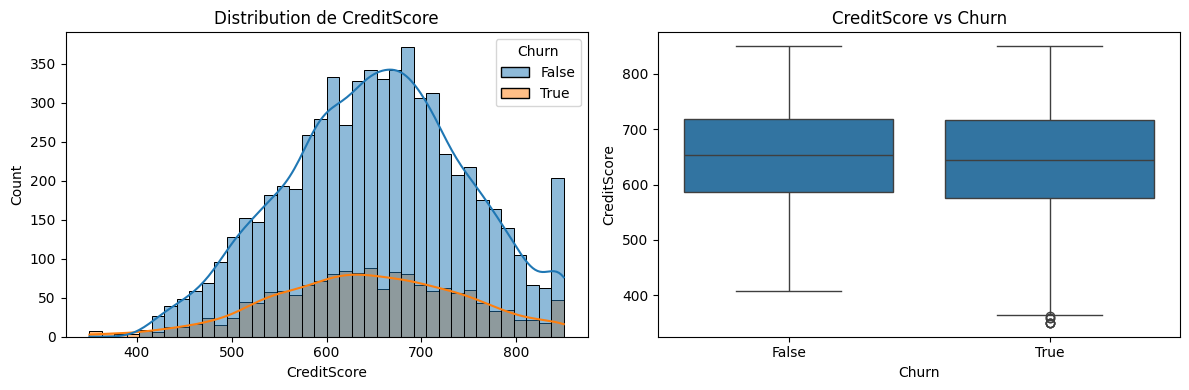

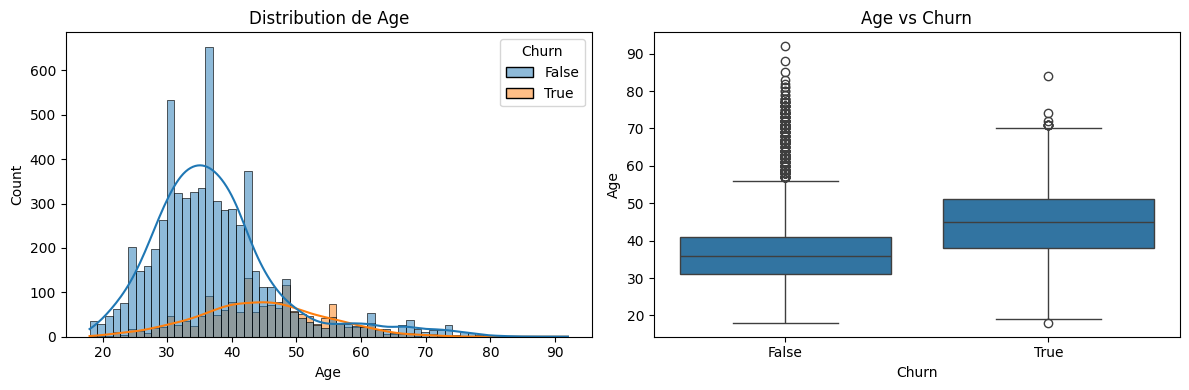

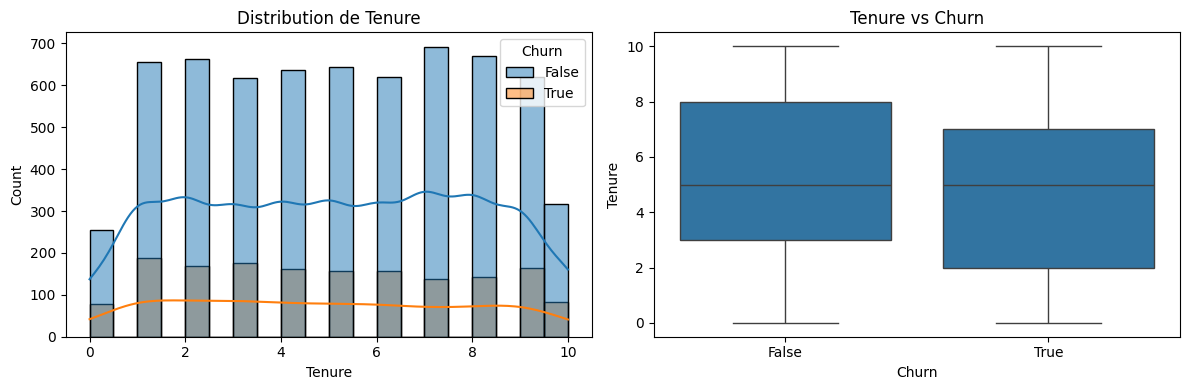

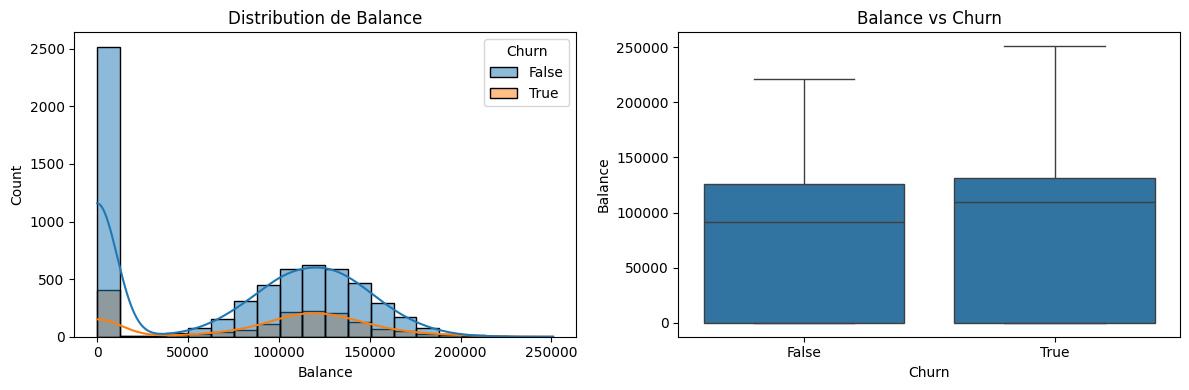

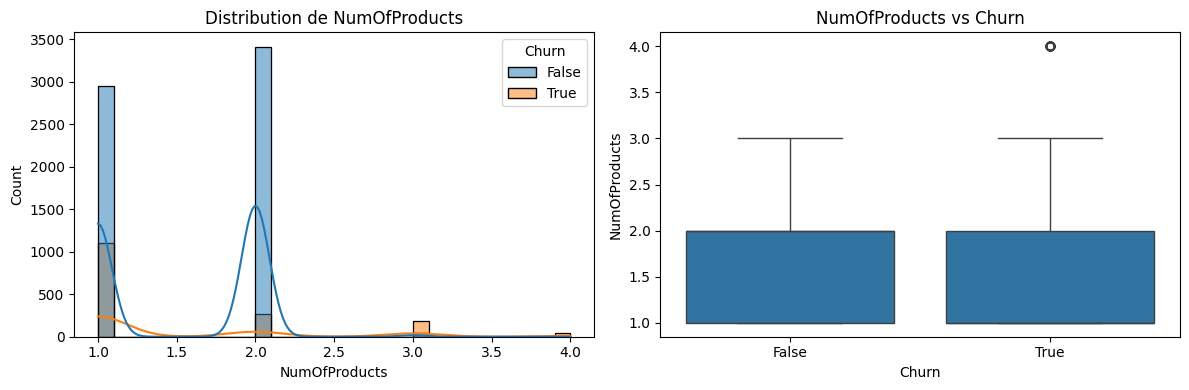

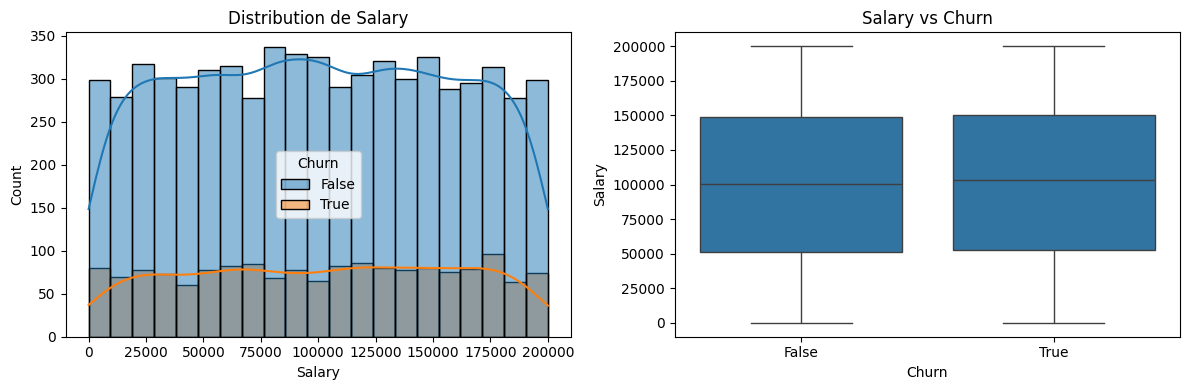

=== Heatmap de corrélation avec la cible ===


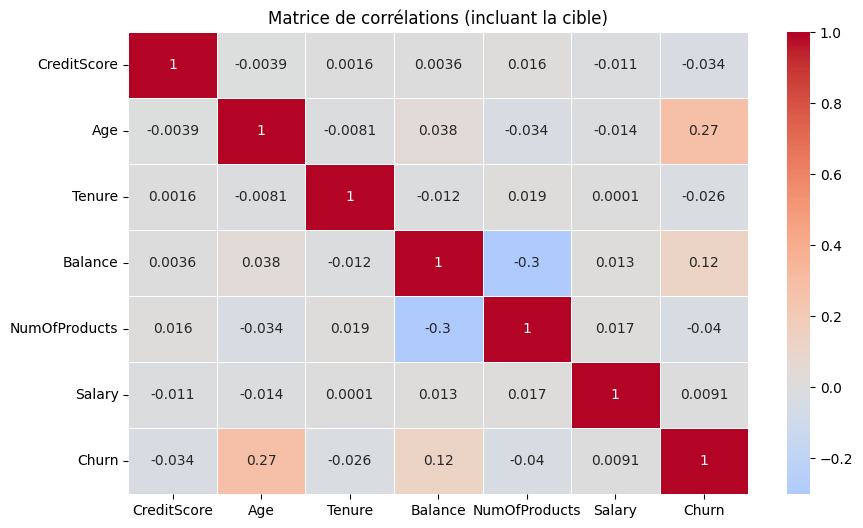

In [62]:
df = X.copy()
df["Churn"] = y["Churn"]
target = "Churn"


print("=== Barplots des variables catégorielles ===")
for col in cat_cols:
    if col == target:
        continue
        
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f"Répartition de {col} par Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


print("=== Histogrammes & Boxplots des variables numériques ===")
for col in num_cols:
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    # Histogram
    sns.histplot(df, x=col, hue=target, kde=True, ax=ax[0])
    ax[0].set_title(f"Distribution de {col}")

    # Boxplot
    sns.boxplot(data=df, x=target, y=col, ax=ax[1])
    ax[1].set_title(f"{col} vs {target}")

    plt.tight_layout()
    plt.show()


print("=== Heatmap de corrélation avec la cible ===")
# encoder la cible en 0/1 pour corr
df_corr = df.copy()
df_corr["Churn"] = df_corr["Churn"].astype(int)

corr = df_corr[num_cols + ["Churn"]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Matrice de corrélations (incluant la cible)")
plt.show()

### Part II - Data processing

In [69]:
X_cv, X_eval, y_cv, y_eval = train_test_split(X, y, test_size=1/8, random_state=42)

OHE = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_cv_cat = OHE.fit_transform(X_cv[cat_cols])
X_eval_cat = OHE.transform(X_eval[cat_cols])

scaler = StandardScaler()
X_cv_num = scaler.fit_transform(X_cv[num_cols])
X_eval_num = scaler.transform(X_eval[num_cols])

X_cv = np.hstack([X_cv_num, X_cv_cat])
X_eval = np.hstack([X_eval_num, X_eval_cat])

y_cv = y_cv.to_numpy().ravel()
y_eval = y_eval.to_numpy().ravel()

### Part III - Model training

In [71]:
logreg_scores = []

shuffle = StratifiedShuffleSplit(n_splits=7, test_size=1/7, random_state=42)
for i, (train_idx, test_idx) in enumerate(shuffle.split(X_cv, y_cv)):
    print(f"Fold {i+1}")
    X_train, X_test = X_cv[train_idx], X_cv[test_idx]
    y_train, y_test = y_cv[train_idx], y_cv[test_idx]

    logreg = LogisticRegression(random_state=42).fit(X_train, y_train)
    logreg_train_score = logreg.score(X_train, y_train)
    print(f"Logistic Regression train score: {logreg_train_score}")
    logreg_test_score = logreg.score(X_test, y_test)
    print(f"Logistic Regression test score: {logreg_test_score}\n")
    logreg_scores.append(logreg_test_score)

logreg_score = np.mean(logreg_scores)
print(f"Logistic Regression final score: {logreg_score}")

Fold 1
Logistic Regression train score: 0.8128333333333333
Logistic Regression test score: 0.812

Fold 2
Logistic Regression train score: 0.813
Logistic Regression test score: 0.81

Fold 3
Logistic Regression train score: 0.8123333333333334
Logistic Regression test score: 0.819

Fold 4
Logistic Regression train score: 0.8131666666666667
Logistic Regression test score: 0.809

Fold 5
Logistic Regression train score: 0.8098333333333333
Logistic Regression test score: 0.817

Fold 6
Logistic Regression train score: 0.8116666666666666
Logistic Regression test score: 0.818

Fold 7
Logistic Regression train score: 0.8116666666666666
Logistic Regression test score: 0.817

Logistic Regression final score: 0.8145714285714286
